## Portfolio simulation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class2 import PortfolioSimulation2
import matplotlib.pyplot as plt

In [2]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})

In [3]:
stock_prices.groupby("date")["price"].sum()

date
2000-01     72192.754303
2000-02     66889.157657
2000-03     81048.646013
2000-04     81904.439908
2000-05     80670.676590
               ...      
2024-08    896788.028594
2024-09    876349.366890
2024-10    858207.668964
2024-11    919455.764807
2024-12    861718.016230
Name: price, Length: 300, dtype: float64

In [4]:
# LLM recommendations
llm_recommendations1 = pd.read_csv("../data/ciks1_ratings.csv", dtype={"cik": str})
llm_recommendations1.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)
llm_recommendations2 = pd.read_csv("../data/ciks2_ratings.csv", dtype={"CIK": str})
llm_recommendations2.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations3 = pd.read_csv("../data/ciks3_ratings.csv", dtype={"CIK": str})
llm_recommendations3.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations4 = pd.read_csv("../data/ciks4_ratings.csv", dtype={"CIK": str})
llm_recommendations4.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations5 = pd.read_csv("../data/ciks5_ratings.csv", dtype={"CIK": str})
llm_recommendations5.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations6 = pd.read_csv("../data/ciks6_ratings.csv", dtype={"CIK": str})
llm_recommendations6.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  

# Concat all llm recommendations into one DataFrame
llm_recommendations = pd.concat([
    llm_recommendations1, llm_recommendations2, llm_recommendations3,
    llm_recommendations4, llm_recommendations5, llm_recommendations6
], ignore_index=True)

In [5]:
import re

def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

---

In [6]:
llm_recommendations = pd.read_csv("../data/ciks1_ratings.csv", dtype={"cik": str})
llm_recommendations.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)

---

- Subsetting CIK date combinations that are present in LLM recommendations as well as sell-side analyst ratings

In [7]:
# Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M")
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M")
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

In [8]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
# Merge to find common CIK and date combinations
all_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

In [9]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)

In [10]:
len(all_ciks_and_dates), len(llm_recommendations_final), len(analyst_ratings_final)

(8119, 8119, 8119)

---
### Selected stock test simulation 

In [11]:
ciks = llm_recommendations_final["cik"].unique()[:1]
ciks

array(['0001996862'], dtype=object)

In [12]:
# Subset 1 CIK for testing
#cik = "0001996862"
cik_prices = stock_prices[stock_prices["cik"].isin([ciks][0])]
cik_llm_recommendations = llm_recommendations_final[llm_recommendations_final["cik"].isin([ciks][0])]
cik_analyst_recommendations = analyst_ratings_final[analyst_ratings_final["cik"].isin([ciks][0])]

In [13]:
start_capital = 100000
cik_sim = PortfolioSimulation2(initial_capital = start_capital)
cik_sim.load_stock_prices(cik_prices)
cik_sim.load_recommendations(cik_llm_recommendations)

# Run simulation
cik_sim.simulate_trading()

Simulating Trades:   0%|          | 0/90 [00:00<?, ?it/s]

Simulating Trades: 100%|██████████| 90/90 [00:00<00:00, 577.52it/s]


In [14]:
cik_sim.portfolio_statistics()

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 886.32it/s]


{'Mean return (monthly)': np.float64(0.001378),
 'Geometric mean return (monthly)': np.float64(0.001284),
 'Standard deviation (monthly)': np.float64(0.014439),
 'Annualized mean return': np.float64(0.016658),
 'Annualized standard deviation': np.float64(0.05002),
 'Number of buys': 3,
 'Number of sells': 2,
 'Total number of transactions': 5,
 'Number of skipped buys': 0,
 'Number of skipped sells': 68,
 'Total number of skipped transactions': 68}

In [15]:
cik_returns = cik_sim.calculate_monthly_returns()
cik_returns

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 970.48it/s]


,month,start_value,end_value,return,normalized_start_value,normalized_end_value
0,2001-10,100000.00,100000.00,0.0,1.000000,1.000000
1,2001-11,100000.00,100000.00,0.0,1.000000,1.000000
2,2001-12,100000.00,100000.00,0.0,1.000000,1.000000
3,2002-01,100000.00,100000.00,0.0,1.000000,1.000000
4,2002-02,100000.00,100000.00,0.0,1.000000,1.000000
...,...,...,...,...,...,...
262,2023-08,140846.39,140846.39,0.0,1.408464,1.408464
263,2023-09,140846.39,140846.39,0.0,1.408464,1.408464
264,2023-10,140846.39,140846.39,0.0,1.408464,1.408464
265,2023-11,140846.39,140846.39,0.0,1.408464,1.408464


In [16]:
cik_sim_positions = cik_sim.get_positions_over_time()
cik_sim_positions = cik_sim_positions.sort_values(by="date")
cik_sim_positions

Getting Positions Over Time: 100%|██████████| 268/268 [00:00<00:00, 1942.97it/s]


,date,cik,quantity,total_value
0,2001-09,cash,100000,100000.00
1,2001-10,cash,100000,100000.00
2,2001-11,cash,100000,100000.00
3,2001-12,cash,100000,100000.00
4,2002-01,cash,100000,100000.00
...,...,...,...,...
270,2023-09,cash,140846,140846.39
271,2023-10,cash,140846,140846.39
272,2023-11,cash,140846,140846.39
273,2023-12,cash,-79,-79.81


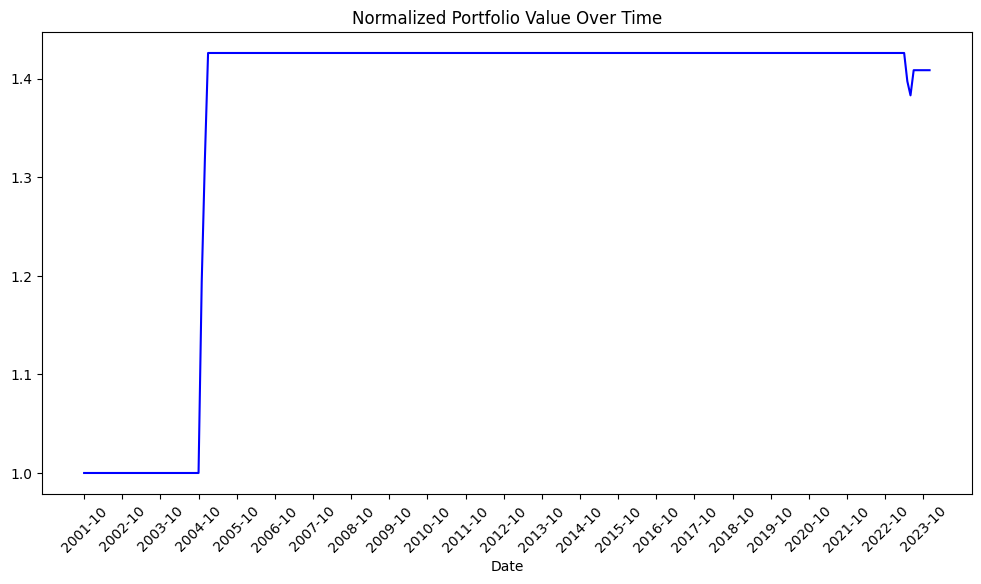

In [17]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = cik_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, cik_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

### LLM recommendations simulation

In [18]:
# Initialize portfolio simulation
llm_sim = PortfolioSimulation2(initial_capital=start_capital)

# Load data
llm_sim.load_stock_prices(stock_prices)
llm_sim.load_recommendations(llm_recommendations_final)

# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 302/302 [01:16<00:00,  3.94it/s]


In [19]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [03:08<00:00,  1.63it/s]


In [20]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.014834),
 'Geometric mean return (monthly)': np.float64(0.011928),
 'Standard deviation (monthly)': np.float64(0.079246),
 'Annualized mean return': np.float64(0.193275),
 'Annualized standard deviation': np.float64(0.274515),
 'Number of buys': 724,
 'Number of sells': 300,
 'Total number of transactions': 1024,
 'Number of skipped buys': 73,
 'Number of skipped sells': 2989,
 'Total number of skipped transactions': 3062}

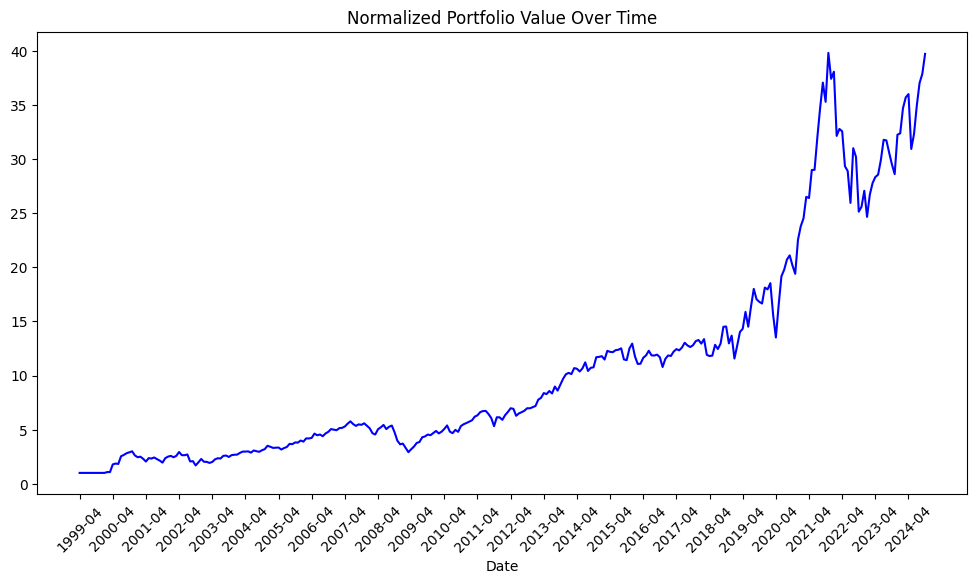

In [21]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = llm_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, llm_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

In [22]:
llm_positions = llm_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 308/308 [01:36<00:00,  3.20it/s]


In [23]:
llm_positions

,date,cik,quantity,total_value
0,1999-03,cash,100000,100000.00
1,1999-04,cash,100000,100000.00
2,1999-05,cash,100000,100000.00
3,1999-06,cash,100000,100000.00
4,1999-07,cash,100000,100000.00
...,...,...,...,...
5531,2024-10,0001845815,7421,63969.02
5532,2024-10,0001955520,1189,115713.48
5533,2024-10,0001532961,6,137.10
5534,2024-10,0001341439,2,335.68


---
### Analyst recommendations simulation

In [24]:
analyst_sim = PortfolioSimulation2(initial_capital=start_capital)
analyst_sim.load_stock_prices(stock_prices)
analyst_sim.load_recommendations(analyst_ratings_final)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 302/302 [01:38<00:00,  3.05it/s]


In [25]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [14:09<00:00,  2.77s/it]


In [26]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.009761),
 'Geometric mean return (monthly)': np.float64(0.007913),
 'Standard deviation (monthly)': np.float64(0.060354),
 'Annualized mean return': np.float64(0.123626),
 'Annualized standard deviation': np.float64(0.209072),
 'Number of buys': 4507,
 'Number of sells': 18,
 'Total number of transactions': 4525,
 'Number of skipped buys': 514,
 'Number of skipped sells': 42,
 'Total number of skipped transactions': 556}

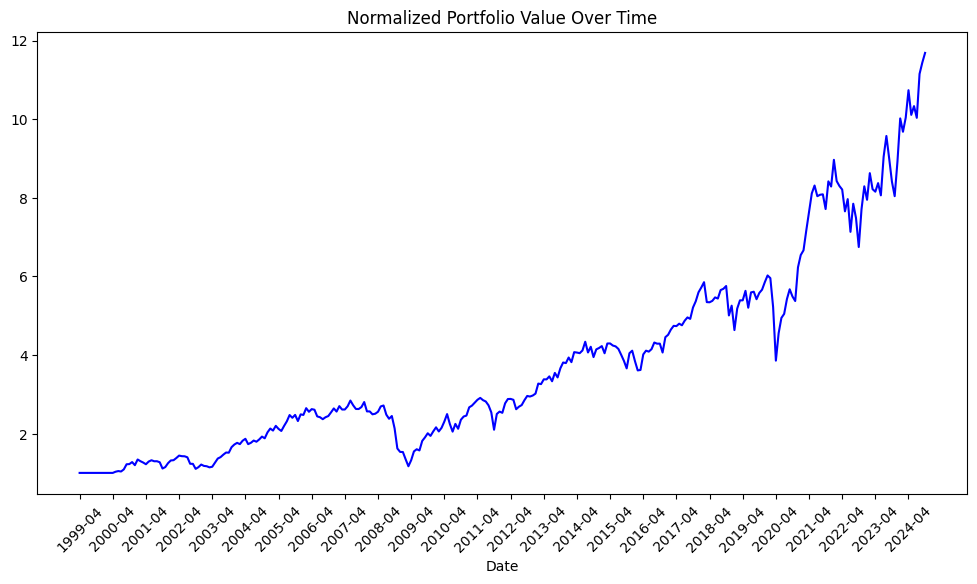

In [27]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = analyst_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, analyst_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

In [28]:
analyst_positions = analyst_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 308/308 [07:13<00:00,  1.41s/it]


In [29]:
df = analyst_positions.reset_index(drop=False)
df

,index,date,cik,quantity,total_value
0,0,1999-03,cash,100000,100000.00
1,1,1999-04,cash,100000,100000.00
2,2,1999-05,cash,100000,100000.00
3,3,1999-06,cash,100000,100000.00
4,4,1999-07,cash,100000,100000.00
...,...,...,...,...,...
22052,22052,2024-10,0001845815,153,1318.86
22053,22053,2024-10,0001620533,6,730.02
22054,22054,2024-10,0000008947,53,4037.54
22055,22055,2024-10,0001341439,23,3860.32


---

#### Analysis of  PF composition over time 

In [30]:
def plot_pf_shares_over_time(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str)  # Ensure date is string for consistency
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.set_index("date", inplace=True)

    plt.figure(figsize=(9, 6))
    plt.plot(dates, pf_shares["cash_share"], label="Cash Share", color="blue")
    plt.plot(dates, pf_shares["stocks_share"], label="Stocks Share", color="orange")

    plt.xticks(dates[::12], rotation=45)


    plt.title("Portfolio Composition Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Share")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


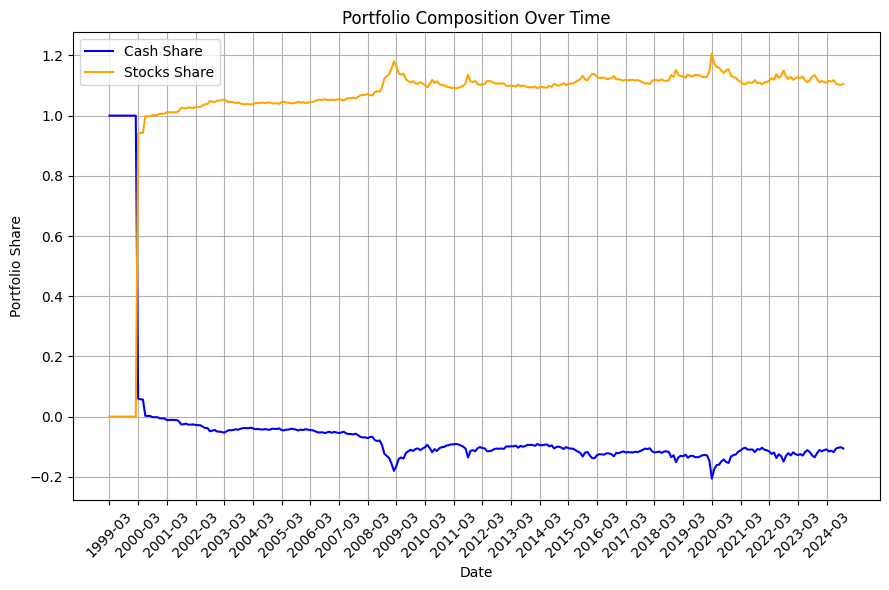

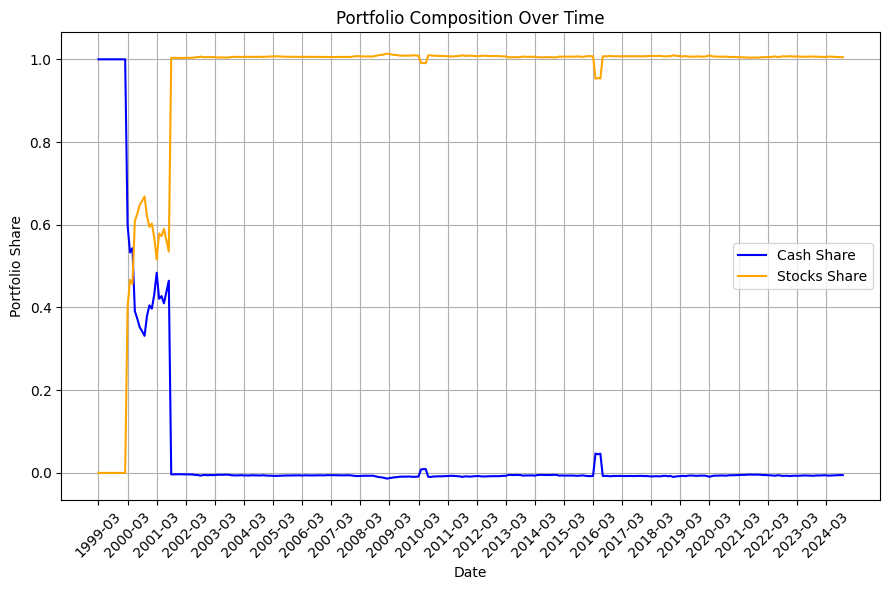

(None, None)

In [31]:
plot_pf_shares_over_time(analyst_positions), plot_pf_shares_over_time(llm_positions)

In [32]:
def plot_pf_shares_over_time2(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str) 
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.sort_values("date", inplace=True)
    pf_shares.set_index("date", inplace=True)

    # Stacked area plot
    plt.figure(figsize=(9, 6))
    plt.stackplot(
        dates,
        pf_shares["cash_share"],
        pf_shares["stocks_share"],
        labels=["Cash", "Stocks"],
        colors=["skyblue", "orange"]
    )

    plt.xticks(dates[::12], rotation=45)
    plt.title("Portfolio Composition Over Time")
    plt.ylabel("Portfolio Share")
    plt.ylim(0, 1)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


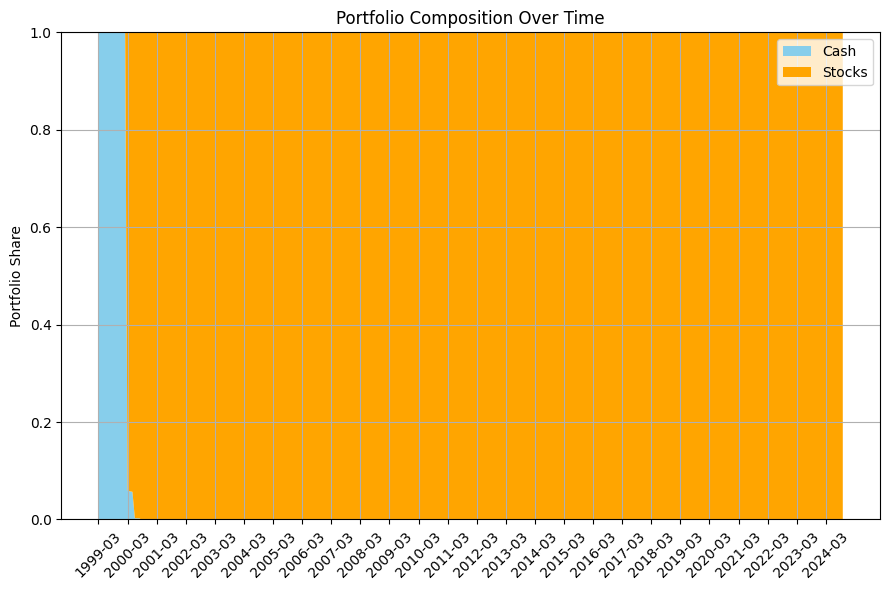

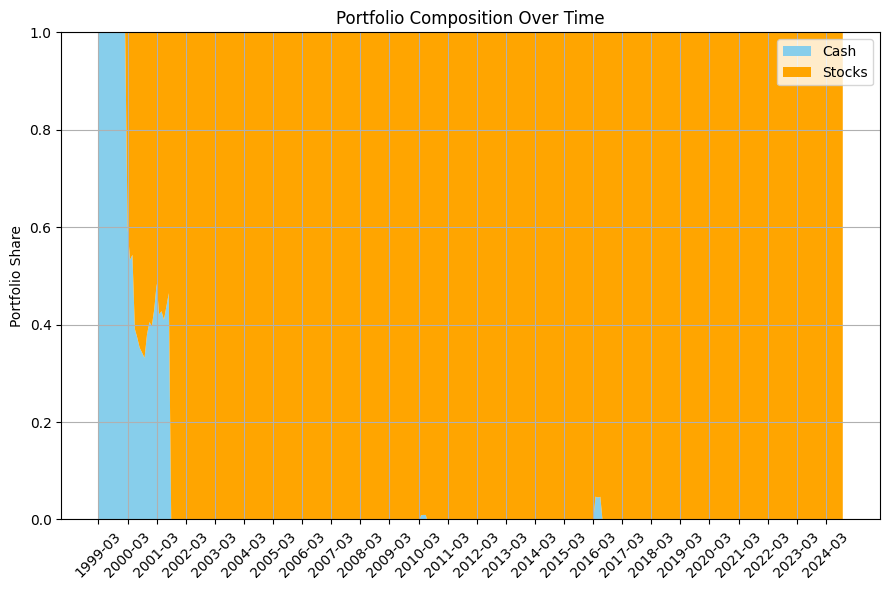

(None, None)

In [33]:
plot_pf_shares_over_time2(analyst_positions), plot_pf_shares_over_time2(llm_positions)